## Count Data

Before we move on to building models of our data we first need to understand the bias present in most modern biological data. The process of accounting for these biases in the mathematical model is often referred to as **normalization** (contrary to the connotation normalization has nothing to do with the normal distribution). **Transformation** of our data (often confused with normalization) can be useful for controlling aspects of our data for visualization or unsupervised learning. In this section, we will focus on count data (e.g. RNA-seq, single-cell, ..etc) as that will likely be the most common data type you will encounter. However, many of these methods are applicable to other data types such as metabolomics data. 



## Normalization

A typical count dataset contains more than one sample with the goal of comparing samples. Unfortunately, due to technical limitations, each sample can have a very different total number of counts. Before we explore methods to account for these biases lets first take a step back to the idea of reference frames. In physics, a reference frame may be a point in space. For example, before asking how fast the earth is moving you must first define the reference point, such as the speed of the earth relative to the sun. In chemistry, the reference point is often the quantity of solute relative to the quantity of the solvent (i.e. concentration). In some cases, a reference frame in biology can be a housekeeping gene (a gene expected to be expressed at a constant level regardless of the conditions). However, in most cases, biological count data does not have a natural biological validated reference frame. 


In order to explore these concepts, we will use a simple toy example. In this example, we have 6 samples (e.g. 6 treatment groups) and 10 features (e.g. a gene) where the entries have counts (e.g. number of genes sequenced in that sample). First, we will generator this data in a hypothetical world where we get the absolute number of gene sequences present in the sample. 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

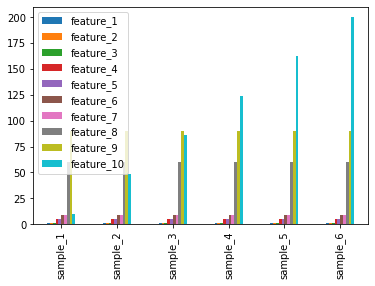

In [226]:
# build the mock data
X = np.vstack([np.append(np.array([1,1,1,5,5,9,9,60,90]), i)
               for i in np.linspace(10, 200, 6)])
index = ['sample_%i' % (i + 1)
         for i in range(X.shape[0])]
column = ['feature_%i' % (i + 1)
          for i in range(X.shape[1])]
# save the mock data
X = pd.DataFrame(X, index, column)
# plot mock daa
X.plot(kind='bar')
plt.show()

From this data, we can see that feature 10 is increasing in the different samples while the other features are increasing. This by itself could be an interesting observation. For example if the samples are different treatments and feature 10 is a gene associated with a clinical outcome we could be seeing an effect of that treatment in gene 10 alone.


However, in only very rare cases will you receive your sequencing count data in absolute values. In almost all cases it will be dependent on random technical factors such as uneven sequencing depth in that sample. As an example, we will subsample our data using a Poisson Log-Normal (see [here](https://academic.oup.com/biomet/article-abstract/76/4/643/254386?redirectedFrom=fulltext) for more details). Based on this we can see that we get randomly variable sequencing depth from out count data (below left). Therefore, numerous normalization methods have been used. One of the most common normalization methods is to estimate the count entries to a total expected sum (e.g. 1 million counts) (below right). 

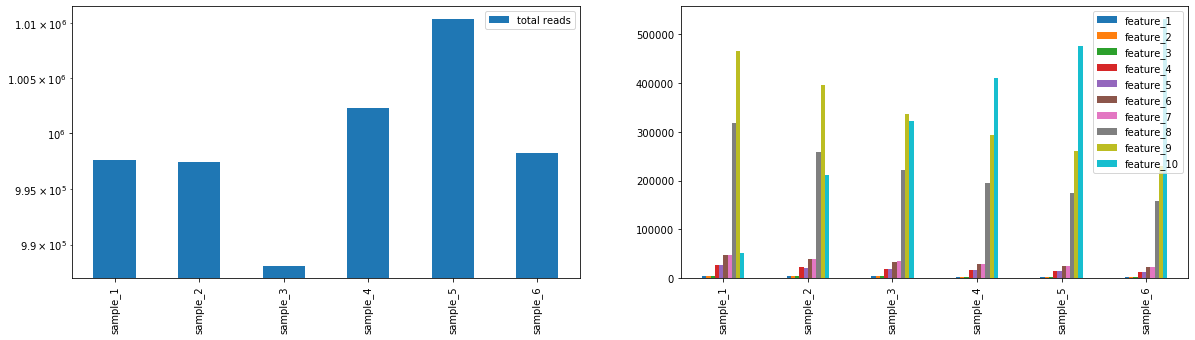

In [227]:
from scipy.stats.mstats import gmean
from skbio.stats.composition import closure

# to prop.
X_sub = closure(X)
# Poisson - Log-Normal Counts
mean = 1e6
stdev = 1e4
phi = (stdev ** 2 + mean ** 2) ** 0.5
mu = mean**2 / phi
mu = np.log(mu * X_sub.T)
sigma = (np.log(phi ** 2 / mean ** 2)) ** 0.5
X_sub = np.vstack([np.random.poisson(np.random.lognormal(mu[:, i], sigma))
                   for i in range(X_sub.shape[0])])
# save the mock data
X_sub = pd.DataFrame(X_sub, index, column)
X_sub_close = pd.DataFrame(closure(X_sub) * mean,
                           index, column)

# plot the results
fig, axn = plt.subplots(1,2,figsize=(20, 5))

# plot mock data totals
pd.DataFrame(X_sub.sum(1), columns=['total reads']).plot(kind='bar', ax=axn[0])
axn[0].set_yscale('log')
# plot mock data norm
X_sub_close.plot(kind='bar', ax=axn[1])

plt.show()

We can see that in the right graph we can still observe feature 10 as increasing with the treatments. However, now we can also observe that all of the other features, once constant are decreasing.  This is an well recognized artifact of the normalization which has inspired many other methods. One commonly used method, employed by DESeq2 (see [here](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/estimateSizeFactorsForMatrix) for details), is to use more stable ratio based estimations based on the median or alternatively the geometric mean. First we will demonstrated why median or geometric mean are used in these ratios instead of the arithmetic mean. For example take sample 1 and the distribution of features. 

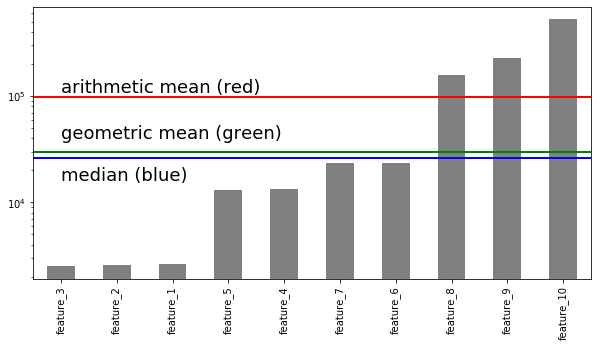

In [228]:
# get estimates
lognrmal = X_sub.loc['sample_3'].values
arthmean = np.mean(lognrmal)
arthmed = np.median(lognrmal)
geommean = gmean(lognrmal)
ratio_est = pd.DataFrame([arthmean, arthmed, geommean],
                        ['arithmetic\nmean','median','geometric\nmean'],
                        ['method'])

# plot the results
fig, ax = plt.subplots(1,1,figsize=(10, 5))

X_sub.loc['sample_6'].sort_values().plot(kind='bar', ax=ax, color='grey')

ax.axhline(arthmean, lw=2, c='red')
ax.text(0, arthmean + 1e4, "arithmetic mean (red)", fontsize=18)

ax.axhline(arthmed, lw=2, c='blue')
ax.text(0, arthmed - 1e4, "median (blue)", fontsize=18)

ax.axhline(geommean, lw=2, c='green')
ax.text(0, geommean + 1e4, "geometric mean (green)", fontsize=18)

ax.set_yscale('log')

plt.show()


As can bee seen in this plot the geometric mean offers a better estimate of the count distribution because the arithmetic mean is easily skewed by large values. Now, we will show this normalization by ratios. 


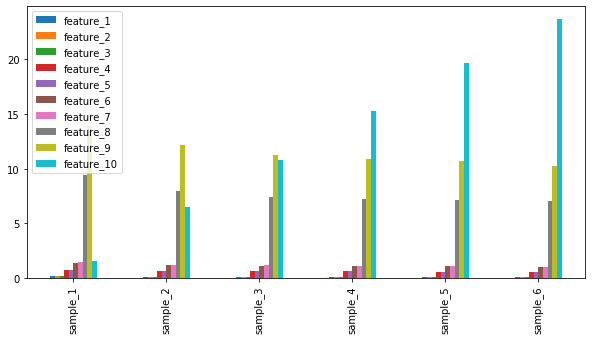

In [230]:
# plot the results
fig, ax = plt.subplots(1,1,figsize=(10, 5))

X_sub_ratio = ((X_sub.T) / gmean(X_sub.T)).T
# plot mock data norm
X_sub_ratio.plot(kind='bar', ax=ax)

plt.show()


As we can see, using this technique of ratios is much more parsimonious. This is why normalization methods based on ratios are highly preferred by researchers (as opposed to constraint based sum). In this example you can view the geometric mean used in the ratio as the reference frame. Understanding normalization is likely the most important step in understanding your count data and it remains a large field of active research. 


## Transformation


Transformations are commonly used for visualizing data and for preprocessing in unsupervised learning. We will cover transformations for unsupervised learning in that section. So for now we will explore aspects of transformations for data exploration, visualization, and confirmations of trends found in models. It may be tempting to say that the ratio of the geometric mean from above shows that feature 10 increases with treatments. However, it is not known that the geometric mean does not change between samples. Just as you cannot separate the reference frame in chemistry and physics you can not do so here and there is no way to know if the geometric mean is changing between treatments. Therefore, many researchers choose to explore the relative importance between two features directly as an log-ratio  (see [here](https://www.nature.com/articles/s41467-019-10656-5#Sec9) for more info).


As an example we can take the log-ratio between feature 1 and feature 10. In ideal world feature 1 would be constant between samples  (e.g. a housekeeping gene). From these log-ratio we can perform statistical tests to verify what our models verify as differentially ranked are indeed that way. 

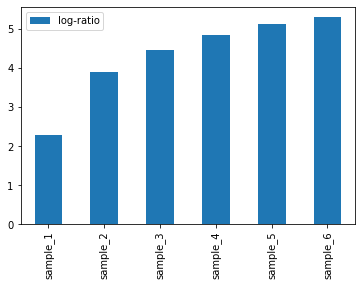

In [235]:
lrdf = pd.DataFrame(np.log(X_sub['feature_10']) - np.log(X_sub['feature_1']), columns=['log-ratio'])
lrdf.plot(kind='bar')
